## Intro to Domino Project

See the getting started [docs](https://docs.dominodatalab.com/en/4.1/get_started/index.html) to set up this project. This notebook outlines step 7, using Jupyter to load, explore, and transform some data. A Launcher will use this notebook to download a new dataset and re-train the model. Graphs in the resulting notebook will represent the new dataset. When the run has been completed, an email will be sent to you and others that you optionally specified in the launcher with the resulting files.

See [this document](https://www.bmreports.com/bmrs/?q=generation/fueltype/current) for information on the data and column headers.

In [1]:
#create default parameters
start_date_str = 'Tue Oct 08 2019 00:00:00 GMT-0700 (Pacific Daylight Time)'
fuel_type = 'CCGT'

In [2]:
#Launcher parameters get passed to the notebook as strings. This command will format these properly for use later
import datetime
today = datetime.datetime.today().strftime('%Y-%m-%d')
start_date = datetime.datetime.strptime(start_date_str.split(' (')[0], '%a %b %d %Y 00:00:00 GMT%z').strftime('%Y-%m-%d')

In [3]:
#retrieve new dataset
!curl -o data.csv "https://www.bmreports.com/bmrs/?q=ajax/filter_csv_download/FUELHH/csv/FromDate%3D{start_date}%26ToDate%3D{today}/&filename=GenerationbyFuelType_20191002_1657" 2>/dev/null

In [4]:
#import the packages we need
%matplotlib inline
import pandas as pd
import datetime

In [5]:
#read in our data
df = pd.read_csv('data.csv', skiprows=1, skipfooter=1, header=None, engine='python')
df = df.iloc[:,0:18]

In [6]:
#rename the columns
df = df.iloc[:,0:18]
df.columns = ['HDF', 'date', 'half_hour_increment',
              'CCGT', 'OIL', 'COAL', 'NUCLEAR',
              'WIND', 'PS', 'NPSHYD', 'OCGT',
              'OTHER', 'INTFR', 'INTIRL', 'INTNED',
               'INTEW', 'BIOMASS', 'INTEM']

#look at our data frame
df.head()

,HDF,date,half_hour_increment,CCGT,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,OCGT,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTEM
0,FUELHH,20191008,1,3461,0,0,6756,9780,0,372,0,72,846,90,102,504,1438,0
1,FUELHH,20191008,2,3460,0,0,6760,9628,0,377,0,72,844,90,102,504,1119,0
2,FUELHH,20191008,3,3484,0,0,6759,9500,0,377,0,72,734,90,102,504,1034,0
3,FUELHH,20191008,4,3569,0,0,6756,9369,0,377,0,72,742,90,102,504,1266,0
4,FUELHH,20191008,5,3505,0,0,6761,9250,0,377,0,72,252,90,102,504,1613,0


In [7]:
#Create a new column datetime that represents the starting datetime of the measured increment
df['datetime'] = pd.to_datetime(df['date'], format="%Y%m%d")
df['datetime'] = df.apply(lambda x:x['datetime']+ datetime.timedelta(minutes=30*(int(x['half_hour_increment'])-1)), 
                          axis = 1)

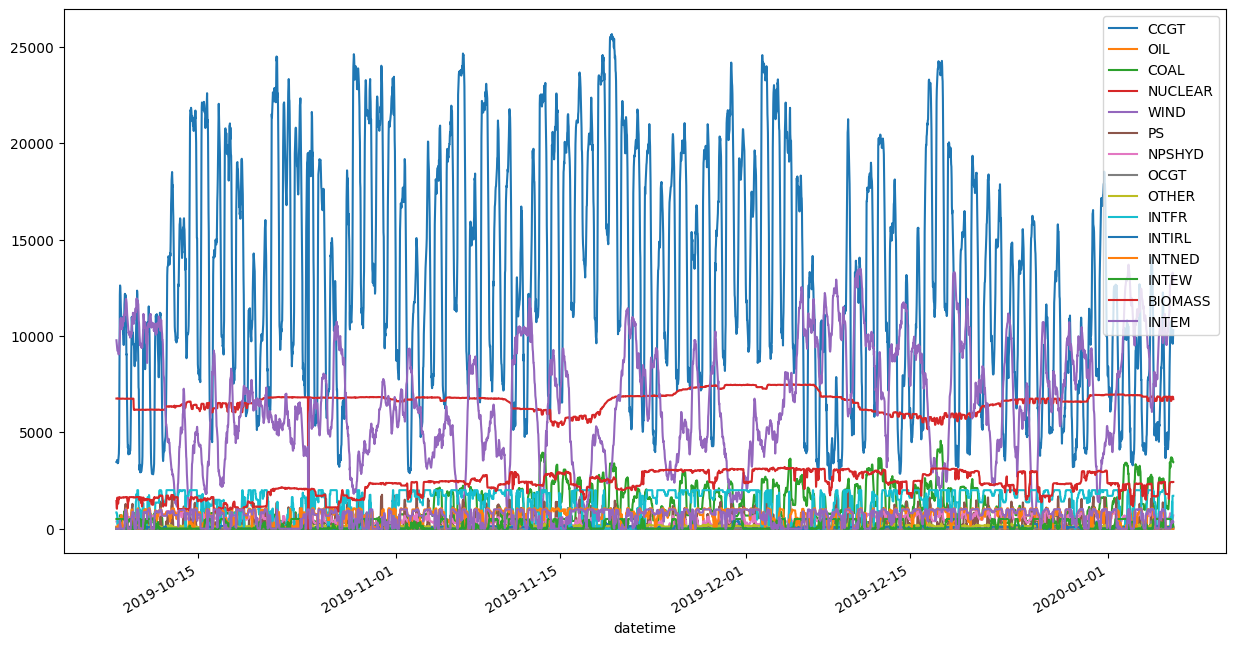

In [8]:
#Visualize the data to see how each fuel type is used during the day by plotting the data
df.drop(['HDF', 'date', 'half_hour_increment'], axis = 1).set_index('datetime').plot(figsize=(15,8));

### Train our model
The CCGT column representing “combined-cycle gas turbines” seems to be the most interesting. It generates a lot of energy and is very volatile.

We will concentrate on this column and try to predict the power generation from this fuel source.

In [9]:
#install Facebook Prophet. Note that this install will not persist beyond this session
#!sudo -H pip install -q --disable-pip-version-check "pystan==2.17.1.0" "plotly<4.0.0"
#!pip install -q --disable-pip-version-check fbprophet

In [10]:
#Prep our data - for Facebook Prophet, the time series data needs to be in a DataFrame with 2 columns named ds and y
df_for_prophet = df[['datetime', fuel_type]].rename(columns = {'datetime':'ds', fuel_type:'y'})

In [11]:
#Split the dataset into train and test sets
X = df_for_prophet.copy()
y = df_for_prophet['y']

proportion_in_training = 0.8
split_index = int(proportion_in_training*len(y))

X_train, y_train = X.iloc[:split_index], y.iloc[:split_index]
X_test, y_test = X.iloc[split_index:], y.iloc[split_index:]

In [12]:
#mport Facebook Prophet and fit a model
from prophet import Prophet

m = Prophet(yearly_seasonality=False)
m.fit(X_train);

09:29:25 - cmdstanpy - INFO - Chain [1] start processing
09:29:25 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
#Make a DataFrame to hold the predictions and predict future values of CCGT power generation

future = m.make_future_dataframe(periods=int(len(y_test)/2), freq='H')
forecast = m.predict(future)

#inspect the dataframe
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3909,2020-01-06 10:00:00,14960.361590,9320.807411,20054.824311
3910,2020-01-06 11:00:00,14580.949583,9132.935630,20044.526112
3911,2020-01-06 12:00:00,14490.559377,9249.134422,19838.967222
3912,2020-01-06 13:00:00,14880.119255,9009.908145,20369.270820
3913,2020-01-06 14:00:00,15474.668077,9661.651159,20861.142443


<Figure size 640x480 with 0 Axes>

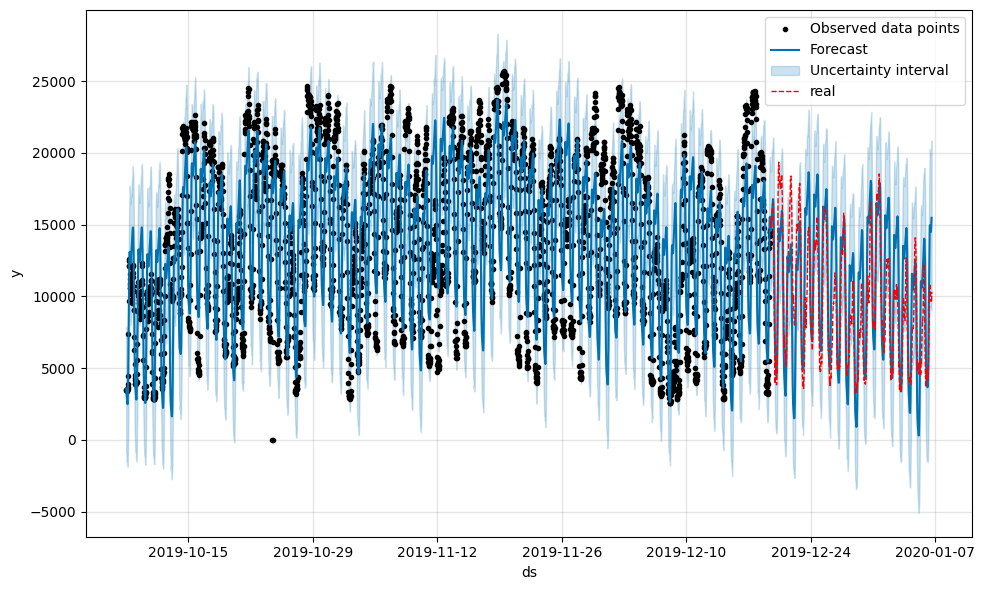

In [14]:
#Plot the fitted line with the training and test data
import matplotlib.pyplot as plt

plt.gcf();
fig = m.plot(forecast);
plt.plot(X_test['ds'].dt.to_pydatetime(), X_test['y'], 'r', linewidth = 1, linestyle = '--', label = 'real');
plt.legend();

### Export trained model
Trained models are meant to be used. There is no reason to re-train the model each time you use the model. Export or serialize the model to a file to load and reuse the model later. In Python, the pickle module implements protocols for serializing and de-serializing objects.

In [16]:
#export the trained model as a pickle file for later use
import pickle
m.stan_backend.logger = None    #uncomment if using Python 3.6 and fbprophet==0.6
with open("model.pkl", "wb") as f:
      pickle.dump(m, f)